# Task 1: CNN Model for Pizza vs. Non-Pizza Classification

  ## 1) Collecting Data

### Dowloading Dataset

In [104]:
# install kaggle
!pip install -q kaggle

In [105]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"tejaszz","key":"90fa745f72e402952c3366b02639b27f"}'}

Loading Kaggle API

In [106]:
# Create a kaggle folder
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [107]:
# Copy the kaggle.json into the created folder
! cp kaggle.json ~/.kaggle/

In [108]:
# Change the permissions of json file
! chmod 600 ~/.kaggle/kaggle.json

Dataset used: Pizza or Not Pizza by CARLOSRUNNER

This dataset contains about 1000 images of pizza and 1000 images of dishes other than pizza. All images were rescaled to have a maximum side length of 512 pixels.

In [109]:
! kaggle datasets download -d carlosrunner/pizza-not-pizza

Dataset URL: https://www.kaggle.com/datasets/carlosrunner/pizza-not-pizza
License(s): other
pizza-not-pizza.zip: Skipping, found more recently modified local copy (use --force to force download)


In [110]:
! unzip pizza-not-pizza.zip

Archive:  pizza-not-pizza.zip
replace pizza_not_pizza/food101_subset.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

### Imports

In [154]:
import torch
import numpy as np
from torch import nn as nn
from torch import optim as optim
from torch.utils.data import random_split
from torchvision import datasets,transforms,models
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import Dataset


In [155]:
torch.__version__

'2.3.0+cu121'

Setting up device agnostic code

In [156]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### How directory structure is formatted

In [157]:
import os
os.getcwd()

'/content'

In [158]:
from pathlib import Path
Path.cwd()

PosixPath('/content')

Looking at the directory structure

In [159]:
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory

  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [160]:
walk_through_dir('/content/pizza_not_pizza/')

There are 2 directories and 1 images in '/content/pizza_not_pizza/'.
There are 0 directories and 983 images in '/content/pizza_not_pizza/not_pizza'.
There are 0 directories and 983 images in '/content/pizza_not_pizza/pizza'.


In [161]:
data_folder = Path("/content/pizza_not_pizza/")
pizza_folder = data_folder / "pizza"
not_pizza_folder = data_folder / '/not_pizza'

In [162]:
data_folder

PosixPath('/content/pizza_not_pizza')

In [163]:
pizza_folder, not_pizza_folder

(PosixPath('/content/pizza_not_pizza/pizza'), PosixPath('/not_pizza'))

## 2) Visualizing Dataset

Random image path: /content/pizza_not_pizza/pizza/2161321.jpg
Image class: pizza
Image height: 512
Image width: 512


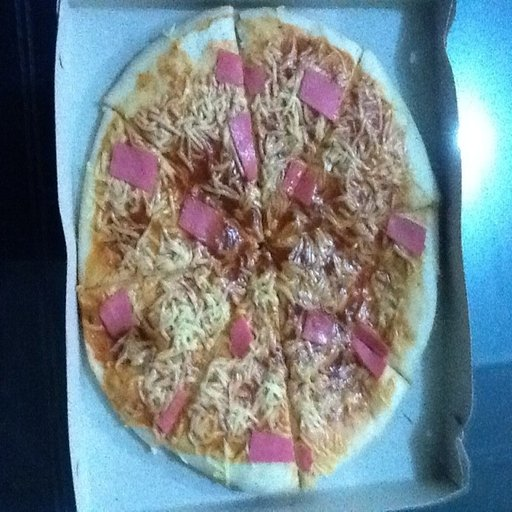

In [164]:
from PIL import Image
import random
from pathlib import Path

random.seed(2)

# Get paths of all images
image_path_list = list(data_folder.glob("*/*.jpg"))

# Get random image path
random_image_path = random.choice(image_path_list)

# Get the image class
image_class = random_image_path.parent.stem

# Open Image
img = Image.open(random_image_path)

# Pring Metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img


## 3) Trasforming Data

In [165]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [166]:
from torchvision.transforms import v2

In [167]:
data_transform = transforms.Compose([
    # Reduce the size of the image
    # transforms.Resize(size=(64,64)), # tried this earlier but the model was underfitting
    transforms.Resize(size=(128,128)),
    v2.RandomHorizontalFlip(p=0.25),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),

    # Data Augmentation
    # transforms.TrivialAugmentWide(num_magnitude_bins=30),
    # Turn the image into a torch.Tenso
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
])

In [168]:
def plot_transformed_images(image_paths, transform, n=3, seed=2):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths.
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)


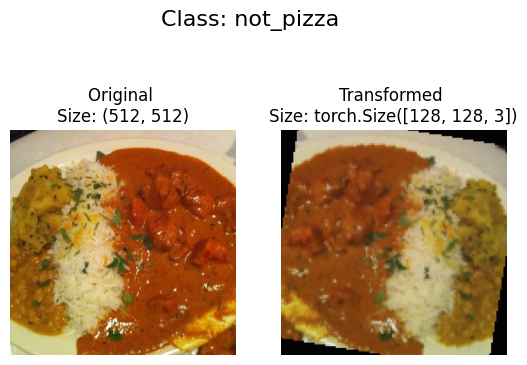

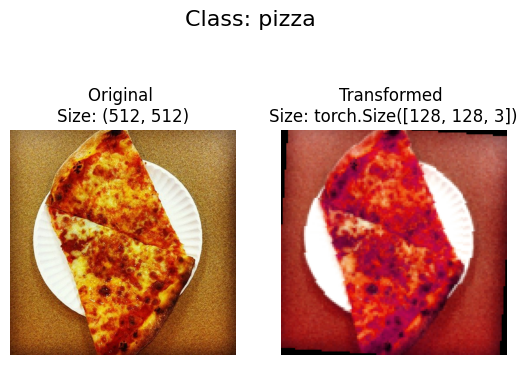

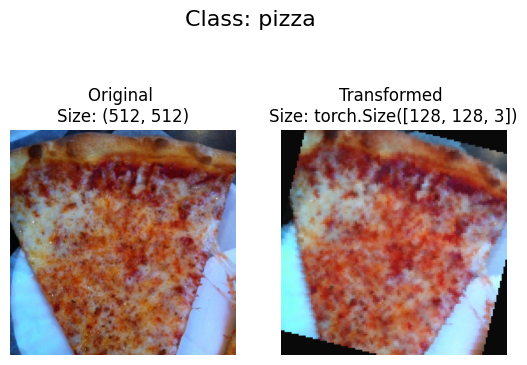

In [169]:
plot_transformed_images(image_path_list, data_transform ,3, 3)

## 4) Loading Data

Now we will have to segregate the dataset into 2 parts: Train and Test

In [170]:
data = datasets.ImageFolder(root=data_folder,
                            transform = data_transform,
                            target_transform = None)


In [171]:
class_names = data.classes
print(class_names)

['not_pizza', 'pizza']


In [172]:
print(data)

Dataset ImageFolder
    Number of datapoints: 1966
    Root location: /content/pizza_not_pizza
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.25)
               RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
               ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.1, 0.1))
               ToTensor()
           )


In [173]:
data[0][0]

tensor([[[0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         ...,
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039]],

        [[0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         ...,
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039]],

        [[0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.

In [174]:
len(data)

1966

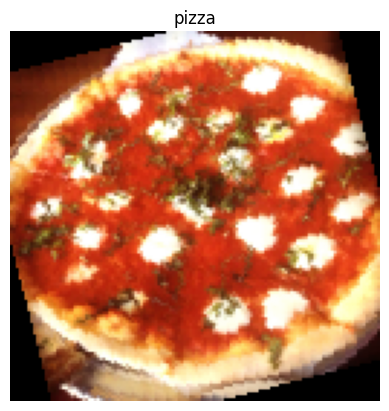

In [175]:
from matplotlib import pyplot as plt
random.seed(1212)
idx = random.randint(0,len(data))
plt.imshow(data[idx][0].permute(1,2,0)) # permute() will change shape of image to suit matplotlib imshow function (RGBC)
plt.title(class_names[data[idx][1]])
plt.axis('off')
plt.show()

In [176]:
TEST_TRAIN_SPLIT = 0.2
test_size = int(TEST_TRAIN_SPLIT * len(data))
train_size = len(data) - test_size
random_seed = 4
torch.manual_seed(random_seed)
train_ds, test_ds = random_split(data, [train_size, test_size])

In [177]:
len(train_ds),len(test_ds)

(1573, 393)

Turn train and test Datasets into DataLoaders

In [178]:
from torch.utils.data import DataLoader

In [179]:
BATCH_SIZE = 8
NUM_WORKERS = os.cpu_count()

In [180]:

train_dataloader = DataLoader(dataset=train_ds,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_ds,
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS,
                             shuffle=False) # don't usually need to shuffle testing data

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7a83bf517f40>,
 <torch.utils.data.dataloader.DataLoader at 0x7a83bf3ed090>)

In [181]:
img, label = next(iter(train_dataloader))
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([8, 3, 128, 128]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([8])


## 5) Create Model Class

In [182]:
# class TinyVGG(nn.Module): # Implementing the tinyVGG architecture
#     def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
#         super().__init__()
#         self.conv1 = nn.Sequential(
#             nn.Conv2d(
#                 in_channels=input_shape,
#                 out_channels=hidden_units,
#                 kernel_size=3,
#                 stride=1,
#                 padding=1 # note that we are using same convolution here
#             ),
#             nn.ReLU(), # Activation Function
#             nn.Conv2d(
#                 in_channels=hidden_units,
#                 out_channels=hidden_units,
#                 kernel_size=3,
#                 stride=1,
#                 padding=1
#             ),
#             nn.ReLU(),
#             nn.MaxPool2d(
#                 kernel_size=2,
#                 stride=2 # default stride value is same askernel_size
#                 )
#         )

#         self.conv2 = nn.Sequential(
#             nn.Conv2d(
#                 in_channels=hidden_units,
#                 out_channels=hidden_units,
#                 kernel_size=3,
#                 stride=1,
#                 padding=1
#             ),
#             nn.ReLU(), # Activation Function
#             nn.Conv2d(
#                 in_channels=hidden_units,
#                 out_channels=hidden_units,
#                 kernel_size=3,
#                 stride=1,
#                 padding=1
#             ),
#             nn.ReLU(),
#             nn.MaxPool2d(
#                 kernel_size=2,
#                 stride=2 # default stride value is same askernel_size
#                 )
#         )

#         self.flat = nn.Sequential(
#             nn.Flatten()
#         )
#         self.fc1 = nn.Sequential(
#             nn.Linear(
#                 in_features=hidden_units * 16 * 16,
#                 out_features=output_shape
#                 )
#         ) #fc layer serves as the final output layer
#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.conv2(x)
#         x = self.flat(x)
#         x = self.fc1(x)
#         return x

In [183]:
# Creating custom model after experimenting
class Model_v2(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int, input_resolution_1d: int):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_shape,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1 # note that we are using same convolution here
            ),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=2,
                stride=2 # default stride value is same askernel_size
                )
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units*2,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(), # Activation Function
            nn.MaxPool2d(
                kernel_size=2,
                stride=2 # default stride value is same askernel_size
                )
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels = hidden_units *2,
                out_channels = hidden_units*4,
                kernel_size = 3,
                stride = 1,
                padding = 1
            ),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size = 2,
                stride = 2
                )
        )


        self.flat = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.25)
        )

        self.fc1 = nn.Sequential(
            nn.Linear(
                in_features=hidden_units * input_resolution_1d * input_resolution_1d // 16,
                out_features=output_shape
                )
                )
        #fc layer serves as the final output layer

    def forward(self, x):
        x = self.conv1(x)
        # print(x.shape)
        x = self.conv2(x)
        # print(x.shape)
        x = self.conv3(x)
        # print(x.shape)
        x = self.flat(x)
        x = self.fc1(x)
        return x

In [184]:
torch.manual_seed(42)
model_0 = Model_v2(input_shape=3,
                   hidden_units=4,
                   output_shape=len(data.classes),
                   input_resolution_1d=128).to(device)


### Forward propogation on one image for sanity check

In [185]:
next(iter(train_dataloader))[0].size()

torch.Size([8, 3, 128, 128])

This means that there are 32 images of these CHW values in a single iterable of the dataloader

In [186]:
# single_img = next(iter(train_dataloader))[0][0]
# unsqueesing was a very important step that I missed. This makes the single_image mathch the shape of the imputs that we expect our model to work on
single_img = next(iter(train_dataloader))[0][0].unsqueeze(dim=0)
single_img.shape
label = next(iter(train_dataloader))[1][0]
single_img.shape, label.shape

(torch.Size([1, 3, 128, 128]), torch.Size([]))

In [187]:
model_0.eval()
with torch.inference_mode():
    pred = model_0(single_img.to(device))

# 4. Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label}")

Output logits:
tensor([[-0.0471, -0.0312]], device='cuda:0')

Output prediction probabilities:
tensor([[0.4960, 0.5040]], device='cuda:0')

Output prediction label:
tensor([1], device='cuda:0')

Actual label:
1


In [188]:
!pip install torchinfo
import torchinfo

from torchinfo import summary
summary(model_0, input_size=[1, 3, 128, 128]) # do a test pass through of an example input size

Layer (type:depth-idx)                   Output Shape              Param #
Model_v2                                 [1, 2]                    --
├─Sequential: 1-1                        [1, 4, 64, 64]            --
│    └─Conv2d: 2-1                       [1, 4, 128, 128]          112
│    └─ReLU: 2-2                         [1, 4, 128, 128]          --
│    └─MaxPool2d: 2-3                    [1, 4, 64, 64]            --
├─Sequential: 1-2                        [1, 8, 32, 32]            --
│    └─Conv2d: 2-4                       [1, 8, 64, 64]            296
│    └─ReLU: 2-5                         [1, 8, 64, 64]            --
│    └─MaxPool2d: 2-6                    [1, 8, 32, 32]            --
├─Sequential: 1-3                        [1, 16, 16, 16]           --
│    └─Conv2d: 2-7                       [1, 16, 32, 32]           1,168
│    └─ReLU: 2-8                         [1, 16, 32, 32]           --
│    └─MaxPool2d: 2-9                    [1, 16, 16, 16]           --
├─Sequenti

## 6) Training

In [189]:
optimizer = torch.optim.Adam(
    params=model_0.parameters(),
    lr=0.001,
    betas=(0.9,0.999), # beta1 and beta2
    eps=1e-8, #epsilon
    )

In [190]:
# optimzer = torch.optim.SGD(model_0.parameters(), lr=0.01)

In [191]:
criterion = nn.CrossEntropyLoss()

In [192]:
'''
training function which trains the model for one epoch
'''

def training(model: torch.nn.Module,
            dataloader: torch.utils.data.DataLoader,
            loss_fn: torch.nn.Module,
            optimizer: torch.optim.Optimizer):
    model.train()   # Put model in train mode
    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader) * 100
    return train_loss, train_acc

In [193]:
'''
testing function which tests the model\]
'''
def testing(model: torch.nn.Module,
            dataloader: torch.utils.data.DataLoader,
            loss_fn: torch.nn.Module,
            optimizer: torch.optim.Optimizer):
    model.eval()
    test_loss, test_acc = 0,0

    with torch.inference_mode():
        for batch,(X,y) in enumerate(dataloader):
            X,y = X.to(device), y.to(device) #sending data to target device, otherwise getting error

            y_pred = model(X)
            loss = loss_fn(y_pred,y)
            test_loss+=loss

            y_pred_class = torch.argmax(y_pred,dim=1)
            test_acc += (y_pred_class == y).sum().item()/len(y_pred)

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader) * 100
    return test_loss, test_acc

In [194]:
from tqdm.auto import tqdm

In [195]:
train_losses = []
test_losses = []
train_accs = []
test_accs = []

In [1]:
epochs = 1

for epoch in tqdm(range(epochs)):
    train_loss, train_acc = training(model=model_0,
                                     dataloader=train_dataloader,
                                     loss_fn=criterion,
                                     optimizer=optimizer)
    test_loss, test_acc = testing(model=model_0,
                                  dataloader=test_dataloader,
                                  loss_fn=criterion,
                                  optimizer=optimizer)
    print(f"Epoch: {epoch+1} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.2f}% | Validation loss: {test_loss:.4f} | Validation acc: {test_acc:.2f}%")

    test_losses.append(test_loss)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

NameError: name 'tqdm' is not defined

In [224]:
for i in range(len(test_losses)):
    if (str(type(test_losses[i]))  != "<class 'float'>"):
        print(type(test_losses[i]))
        test_losses[i] = test_losses[i].cpu().item()
        # test_losses[i] = test_losses[i].cpu().item()
# for loss in train_losses:
#     loss = loss.cpu()
# for acc in test_accs:
#     acc = acc.cpu()
# for acc in train_accs:
#     acc = acc.cpu()

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'tor

In [219]:
type(test_losses[0])

float

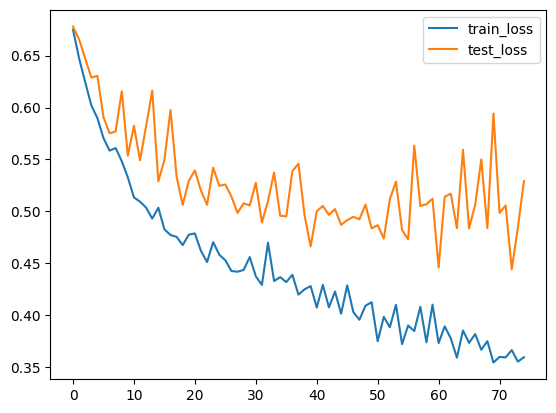

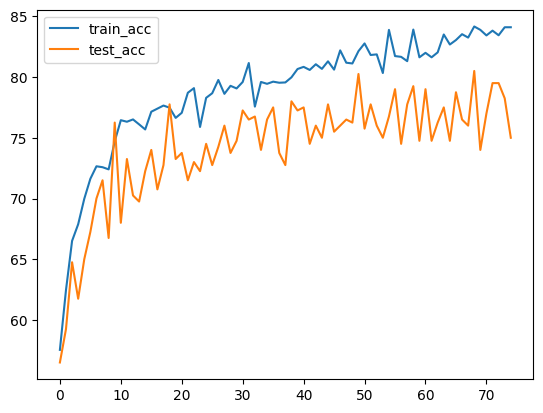

<Figure size 640x480 with 0 Axes>

In [226]:
from matplotlib import pyplot as plt
# test_losses_cpu = [loss.cpu().detach().numpy() for loss in test_losses]

plt.plot(train_losses, label="train_loss")
plt.plot(test_losses, label="test_loss")
plt.legend()
plt.show()
plt.plot(train_accs, label="train_acc")
plt.plot(test_accs, label="test_acc")
plt.legend()
plt.show()
plt.savefig('model_v2_training.png')

In [200]:
len(train_losses)

30

In [201]:
# from pathlib import Path

# # 1. Create models directory
# MODEL_PATH = Path("models")
# MODEL_PATH.mkdir(parents=True, exist_ok=True)

# # 2. Create model save path
# MODEL_NAME = "01_pytorch_workflow_model_1.pth"
# MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# # 3. Save the model state dict
# print(f"Saving model to: {MODEL_SAVE_PATH}")
# torch.save(obj=model_0.state_dict(), # only saving the state_dict() only saves the models learned parameters
#            f=MODEL_SAVE_PATH)

In [202]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
